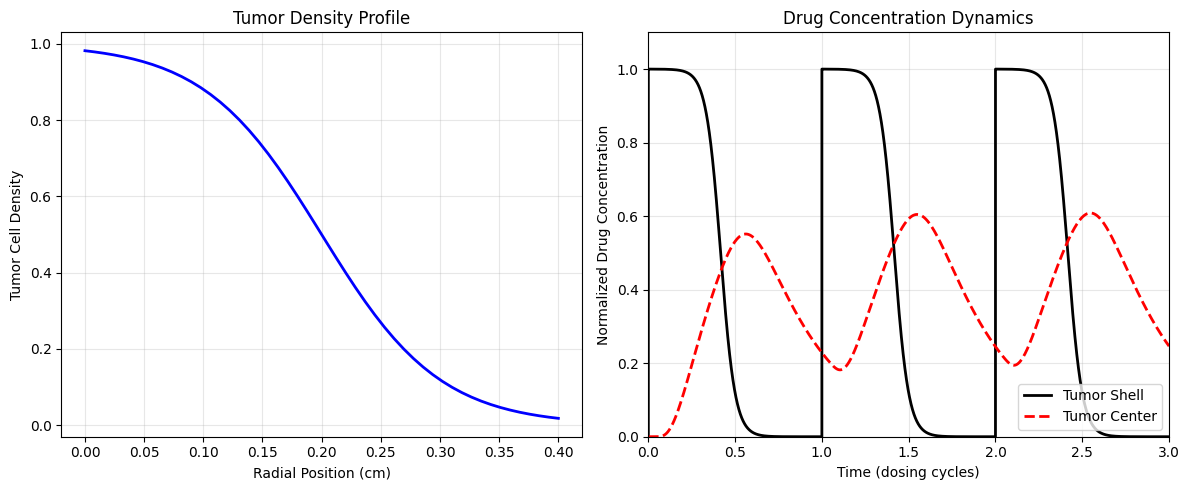

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Parameters
tau_cycle = 1440    # Dosing period (minutes)
tau_decay = 600     # Decay time (minutes)
t_max = 3*tau_cycle # Simulate 3 cycles
dt = 0.1            # Reduced time step for stability
Nx = 50             # Spatial grid points
r_max = 0.4         # Tumor radius (cm)

# Grid setup
time = np.arange(0, t_max, dt)
r = np.linspace(0, r_max, Nx)
dr = r[1] - r[0]

# Tumor density profile (sigmoid function)
def tumor_density(r, r0=0.2, sigma=0.05):
    return 1 / (1 + np.exp((r - r0)/sigma))
n = tumor_density(r)  # Array of tumor densities

# PBPK dosing function
def S_t(t, C0=1.0):
    cycle_time = t % tau_cycle
    return C0 / (1 + np.exp((cycle_time - tau_decay)/(tau_decay/10)))

# Reaction-diffusion parameters
D = 5e-5            # Increased diffusion coefficient
k_met = 1e-5         # Reduced metabolism rate
lambda_14 = 2.5e-5   # Base consumption rate
phi_0 = 0.1          # Increased saturation constant

# Initialize concentration
C = np.zeros((Nx, len(time)))

# Main simulation loop
for t_idx in range(1, len(time)):
    t = time[t_idx]
    
    # Boundary condition at shell
    C[-1, t_idx] = S_t(t)
    
    # Update interior points
    for i in range(Nx):
        if i == 0:
            # Center point - symmetry boundary
            laplacian = 2*(C[i+1, t_idx-1] - C[i, t_idx-1])/dr**2
        elif i == Nx-1:
            continue  # Boundary already set
        else:
            # Radial diffusion operator
            r_i = max(r[i], 1e-6)  # Avoid division by zero
            laplacian = ((C[i+1, t_idx-1] - 2*C[i, t_idx-1] + C[i-1, t_idx-1])/dr**2 +
                       (1/r_i)*(C[i+1, t_idx-1] - C[i-1, t_idx-1])/(2*dr))
        
        # Tumor-density dependent consumption
        lambda_0 = lambda_14 * n[i]
        reaction = -k_met*C[i, t_idx-1] - lambda_0*C[i, t_idx-1]/(C[i, t_idx-1] + phi_0)
        
        # Update concentration
        C[i, t_idx] = C[i, t_idx-1] + dt*(D*laplacian + reaction)
    
    # Ensure non-negative concentrations
    C[:, t_idx] = np.maximum(0, C[:, t_idx])

# Normalize concentrations
C_max = np.max(C)
if C_max > 0:
    C_normalized = C/C_max
else:
    C_normalized = C

# Extract profiles
C_shell = C_normalized[-1, :]
C_center = C_normalized[0, :]

# Plot results
plt.figure(figsize=(12, 5))

# Tumor density profile
plt.subplot(1, 2, 1)
plt.plot(r, n, 'b-', linewidth=2)
plt.xlabel('Radial Position (cm)')
plt.ylabel('Tumor Cell Density')
plt.title('Tumor Density Profile')
plt.grid(alpha=0.3)

# Concentration profiles
plt.subplot(1, 2, 2)
plt.plot(time/tau_cycle, C_shell, 'k-', linewidth=2, label="Tumor Shell")
plt.plot(time/tau_cycle, C_center, 'r--', linewidth=2, label="Tumor Center")
plt.xlabel('Time (dosing cycles)')
plt.ylabel('Normalized Drug Concentration')
plt.title('Drug Concentration Dynamics')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1.1)
plt.xlim(0, 3)

plt.tight_layout()
plt.show()

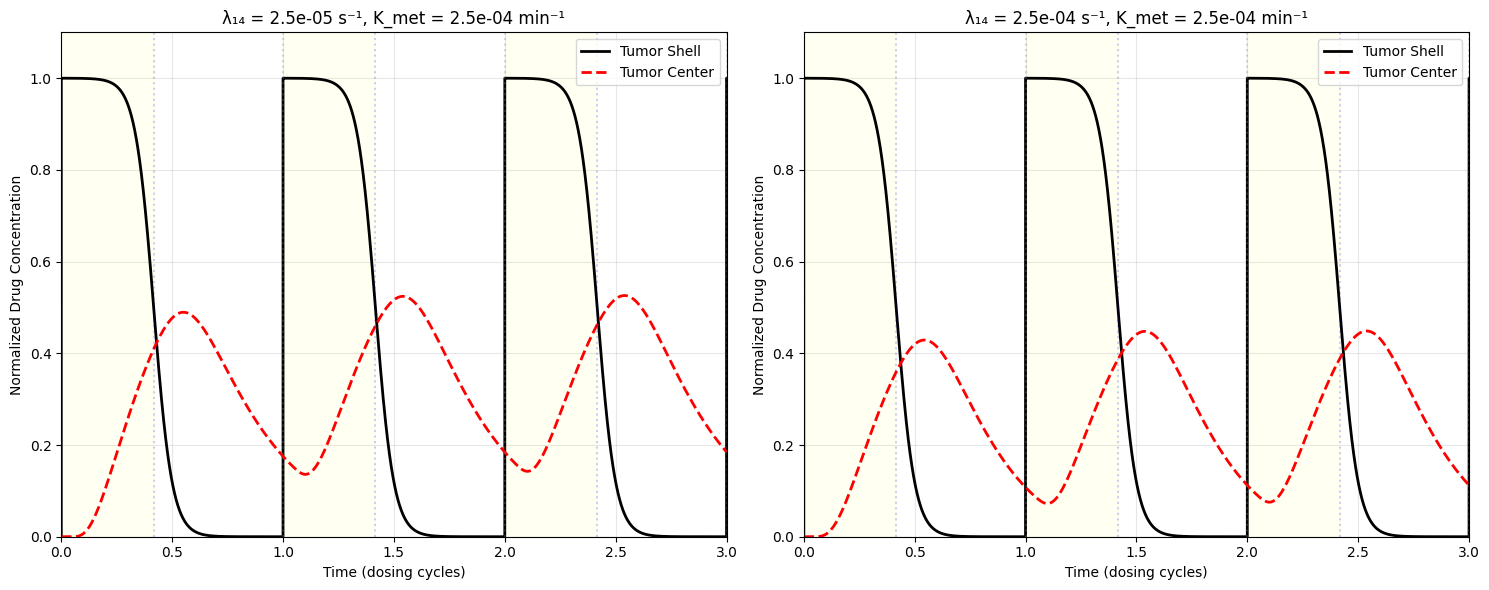

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
tau_cycle = 1440    # Dosing period (minutes)
tau_decay = 600    # Decay time (minutes)
t_max = 6*tau_cycle # Simulate 3 cycles
dt = 0.1            # Time step (minutes)
Nx = 50             # Spatial grid points
r_max = 0.4         # Tumor radius (cm)

# Grid setup
time = np.arange(0, t_max, dt)
r = np.linspace(0, r_max, Nx)
dr = r[1] - r[0]

# Tumor density profile (sigmoid function)
def tumor_density(r, r0=0.2, sigma=0.05):
    return 1 / (1 + np.exp((r - r0)/sigma))
n = tumor_density(r)

# PBPK dosing function
def S_t(t, C0=1.0):
    cycle_time = t % tau_cycle
    return C0 / (1 + np.exp((cycle_time - tau_decay)/(tau_decay/10)))

# Reaction-diffusion parameters
D = 5e-5            # Diffusion coefficient (cm²/s)
K_met = 2.5e-4      # Metabolism rate (1/min)
phi_0 = 0.05        # Saturation constant
lambda_values = [2.5e-5, 2.5e-4]  # Two λ₁₄ values to compare

# Initialize figures
plt.figure(figsize=(15, 6))

# Simulation for both λ₁₄ values
for case, lambda_14 in enumerate(lambda_values):
    # Initialize concentration
    C = np.zeros((Nx, len(time)))
    
    # Main simulation loop
    for t_idx in range(1, len(time)):
        t = time[t_idx]
        
        # Boundary condition at shell
        C[-1, t_idx] = S_t(t)
        
        # Update interior points
        for i in range(Nx):
            if i == 0:
                # Center point - symmetry boundary
                laplacian = 2*(C[i+1, t_idx-1] - C[i, t_idx-1])/dr**2
            elif i == Nx-1:
                continue  # Boundary already set
            else:
                # Radial diffusion operator
                r_i = max(r[i], 1e-6)  # Avoid division by zero
                laplacian = ((C[i+1, t_idx-1] - 2*C[i, t_idx-1] + C[i-1, t_idx-1])/dr**2 +
                           (1/r_i)*(C[i+1, t_idx-1] - C[i-1, t_idx-1])/(2*dr))
            
            # Tumor-density dependent consumption
            lambda_0 = lambda_14 * n[i]
            reaction = -K_met*C[i, t_idx-1] - lambda_0*C[i, t_idx-1]/(C[i, t_idx-1] + phi_0)
            
            # Update concentration
            C[i, t_idx] = C[i, t_idx-1] + dt*(D*laplacian + reaction)
        
        # Ensure non-negative concentrations
        C[:, t_idx] = np.maximum(0, C[:, t_idx])
    
    # Normalize concentrations
    C_max = np.max(C)
    if C_max > 0:
        C_normalized = C/C_max
    else:
        C_normalized = C
    
    # Extract profiles
    C_shell = C_normalized[-1, :]
    C_center = C_normalized[0, :]
    
    # Create subplot for this case
    plt.subplot(1, 2, case+1)
    plt.plot(time/tau_cycle, C_shell, 'k-', linewidth=2, label="Tumor Shell")
    plt.plot(time/tau_cycle, C_center, 'r--', linewidth=2, label="Tumor Center")
    
    # Mark dosing periods
    for cycle in range(4):
        plt.axvline(x=cycle, color='gray', linestyle=':', alpha=0.3)
        plt.axvline(x=cycle + tau_decay/tau_cycle, color='blue', linestyle=':', alpha=0.2)
        plt.axvspan(cycle, cycle + tau_decay/tau_cycle, color='yellow', alpha=0.05)
    
    plt.xlabel('Time (dosing cycles)')
    plt.ylabel('Normalized Drug Concentration')
    plt.title(f'λ₁₄ = {lambda_14:.1e} s⁻¹, K_met = {K_met:.1e} min⁻¹')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim(0, 1.1)
    plt.xlim(0, 3)

plt.tight_layout()
plt.show()

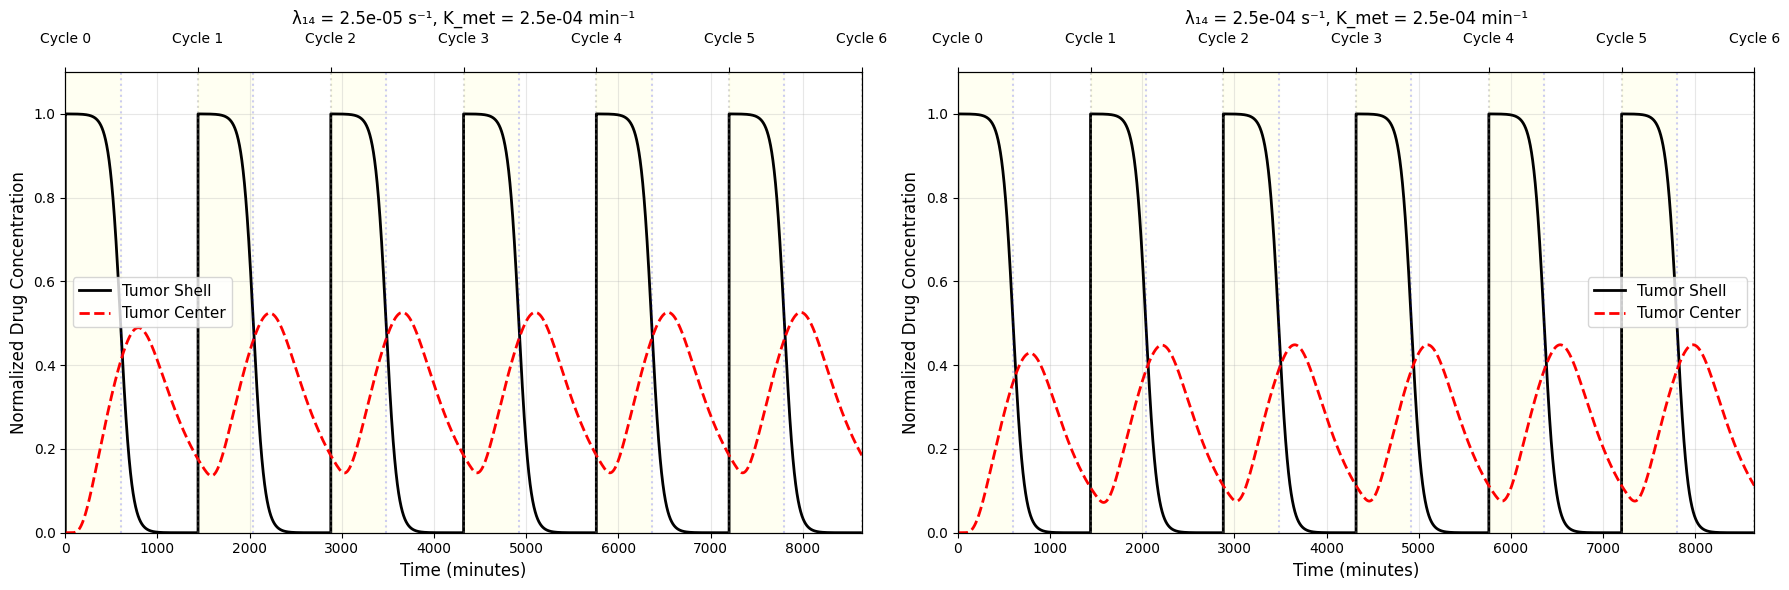

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
tau_cycle = 1440    # Dosing period (minutes)
tau_decay = 600     # Decay time (minutes)
t_max = 6*tau_cycle # Simulate 6 cycles
dt = 0.1            # Time step (minutes)
Nx = 50             # Spatial grid points
r_max = 0.4         # Tumor radius (cm)

# Grid setup
time = np.arange(0, t_max, dt)
r = np.linspace(0, r_max, Nx)
dr = r[1] - r[0]

# Tumor density profile (sigmoid function)
def tumor_density(r, r0=0.2, sigma=0.05):
    return 1 / (1 + np.exp((r - r0)/sigma))
n = tumor_density(r)

# PBPK dosing function
def S_t(t, C0=1.0):
    cycle_time = t % tau_cycle
    return C0 / (1 + np.exp((cycle_time - tau_decay)/(tau_decay/10)))

# Reaction-diffusion parameters
D = 5e-5            # Diffusion coefficient (cm²/s)
K_met = 2.5e-4      # Metabolism rate (1/min)
phi_0 = 0.05        # Saturation constant
lambda_values = [2.5e-5, 2.5e-4]  # Two λ₁₄ values to compare

# Initialize figures with wider size
plt.figure(figsize=(18, 6))

# Simulation for both λ₁₄ values
for case, lambda_14 in enumerate(lambda_values):
    # Initialize concentration
    C = np.zeros((Nx, len(time)))
    
    # Main simulation loop
    for t_idx in range(1, len(time)):
        t = time[t_idx]
        
        # Boundary condition at shell
        C[-1, t_idx] = S_t(t)
        
        # Update interior points
        for i in range(Nx):
            if i == 0:
                # Center point - symmetry boundary
                laplacian = 2*(C[i+1, t_idx-1] - C[i, t_idx-1])/dr**2
            elif i == Nx-1:
                continue  # Boundary already set
            else:
                # Radial diffusion operator
                r_i = max(r[i], 1e-6)  # Avoid division by zero
                laplacian = ((C[i+1, t_idx-1] - 2*C[i, t_idx-1] + C[i-1, t_idx-1])/dr**2 +
                           (1/r_i)*(C[i+1, t_idx-1] - C[i-1, t_idx-1])/(2*dr))
            
            # Tumor-density dependent consumption
            lambda_0 = lambda_14 * n[i]
            reaction = -K_met*C[i, t_idx-1] - lambda_0*C[i, t_idx-1]/(C[i, t_idx-1] + phi_0)
            
            # Update concentration
            C[i, t_idx] = C[i, t_idx-1] + dt*(D*laplacian + reaction)
        
        # Ensure non-negative concentrations
        C[:, t_idx] = np.maximum(0, C[:, t_idx])
    
    # Normalize concentrations
    C_max = np.max(C)
    if C_max > 0:
        C_normalized = C/C_max
    else:
        C_normalized = C
    
    # Extract profiles
    C_shell = C_normalized[-1, :]
    C_center = C_normalized[0, :]
    
    # Create subplot for this case
    plt.subplot(1, 2, case+1)
    
    # Plot with time in minutes
    plt.plot(time, C_shell, 'k-', linewidth=2, label="Tumor Shell")
    plt.plot(time, C_center, 'r--', linewidth=2, label="Tumor Center")
    
    # Mark dosing periods (in minutes)
    for cycle in range(7):  # For 6 cycles plus start of 7th
        cycle_start = cycle * tau_cycle
        decay_start = cycle_start + tau_decay
        plt.axvline(x=cycle_start, color='gray', linestyle=':', alpha=0.3)
        plt.axvline(x=decay_start, color='blue', linestyle=':', alpha=0.2)
        plt.axvspan(cycle_start, decay_start, color='yellow', alpha=0.05)
    
    # Format x-axis in minutes
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Normalized Drug Concentration', fontsize=12)
    plt.title(f'λ₁₄ = {lambda_14:.1e} s⁻¹, K_met = {K_met:.1e} min⁻¹', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.ylim(0, 1.1)
    plt.xlim(0, 6*tau_cycle)  # Show all 6 cycles in minutes
    
    # Add secondary x-axis showing cycle numbers
    ax = plt.gca()
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(np.arange(0, 7*tau_cycle, tau_cycle))
    ax2.set_xticklabels([f'Cycle {i}' for i in range(7)])
    ax2.tick_params(axis='x', which='major', pad=15)

plt.tight_layout()
plt.show()

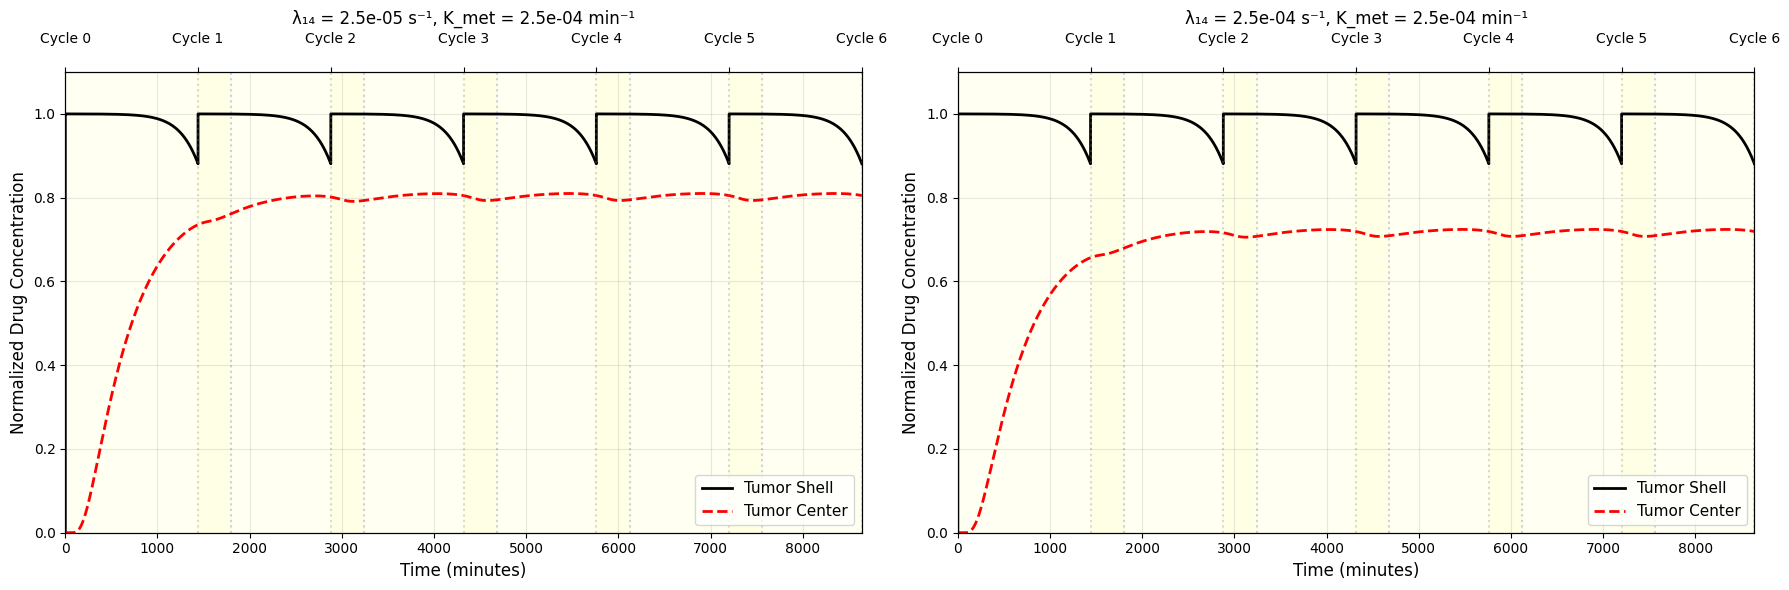

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
tau_cycle = 1440    # Dosing period (minutes)
tau_decay = 1800    # Decay time (minutes)
t_max = 6*tau_cycle # Simulate 6 cycles
dt = 0.1            # Time step (minutes)
Nx = 50             # Spatial grid points
r_max = 0.4         # Tumor radius (cm)

# Grid setup
time = np.arange(0, t_max, dt)
r = np.linspace(0, r_max, Nx)
dr = r[1] - r[0]

# Tumor density profile (sigmoid function)
def tumor_density(r, r0=0.2, sigma=0.05):
    return 1 / (1 + np.exp((r - r0)/sigma))
n = tumor_density(r)

# PBPK dosing function
def S_t(t, C0=1.0):
    cycle_time = t % tau_cycle
    return C0 / (1 + np.exp((cycle_time - tau_decay)/(tau_decay/10)))

# Reaction-diffusion parameters
D = 5e-5            # Diffusion coefficient (cm²/s)
K_met = 2.5e-4      # Metabolism rate (1/min)
phi_0 = 0.05        # Saturation constant
lambda_values = [2.5e-5, 2.5e-4]  # Two λ₁₄ values to compare

# Initialize figures with wider size
plt.figure(figsize=(18, 6))

# Simulation for both λ₁₄ values
for case, lambda_14 in enumerate(lambda_values):
    # Initialize concentration
    C = np.zeros((Nx, len(time)))
    
    # Main simulation loop
    for t_idx in range(1, len(time)):
        t = time[t_idx]
        
        # Boundary condition at shell
        C[-1, t_idx] = S_t(t)
        
        # Update interior points
        for i in range(Nx):
            if i == 0:
                # Center point - symmetry boundary
                laplacian = 2*(C[i+1, t_idx-1] - C[i, t_idx-1])/dr**2
            elif i == Nx-1:
                continue  # Boundary already set
            else:
                # Radial diffusion operator
                r_i = max(r[i], 1e-6)  # Avoid division by zero
                laplacian = ((C[i+1, t_idx-1] - 2*C[i, t_idx-1] + C[i-1, t_idx-1])/dr**2 +
                           (1/r_i)*(C[i+1, t_idx-1] - C[i-1, t_idx-1])/(2*dr))
            
            # Tumor-density dependent consumption
            lambda_0 = lambda_14 * n[i]
            reaction = -K_met*C[i, t_idx-1] - lambda_0*C[i, t_idx-1]/(C[i, t_idx-1] + phi_0)
            
            # Update concentration
            C[i, t_idx] = C[i, t_idx-1] + dt*(D*laplacian + reaction)
        
        # Ensure non-negative concentrations
        C[:, t_idx] = np.maximum(0, C[:, t_idx])
    
    # Normalize concentrations
    C_max = np.max(C)
    if C_max > 0:
        C_normalized = C/C_max
    else:
        C_normalized = C
    
    # Extract profiles
    C_shell = C_normalized[-1, :]
    C_center = C_normalized[0, :]
    
    # Create subplot for this case
    plt.subplot(1, 2, case+1)
    
    # Plot with time in minutes
    plt.plot(time, C_shell, 'k-', linewidth=2, label="Tumor Shell")
    plt.plot(time, C_center, 'r--', linewidth=2, label="Tumor Center")
    
    # Mark dosing periods (in minutes)
    for cycle in range(7):  # For 6 cycles plus start of 7th
        cycle_start = cycle * tau_cycle
        decay_start = cycle_start + tau_decay
        plt.axvline(x=cycle_start, color='gray', linestyle=':', alpha=0.3)
        plt.axvline(x=decay_start, color='blue', linestyle=':', alpha=0.2)
        plt.axvspan(cycle_start, decay_start, color='yellow', alpha=0.05)
    
    # Format x-axis in minutes
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Normalized Drug Concentration', fontsize=12)
    plt.title(f'λ₁₄ = {lambda_14:.1e} s⁻¹, K_met = {K_met:.1e} min⁻¹', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.ylim(0, 1.1)
    plt.xlim(0, 6*tau_cycle)  # Show all 6 cycles in minutes
    
    # Add secondary x-axis showing cycle numbers
    ax = plt.gca()
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(np.arange(0, 7*tau_cycle, tau_cycle))
    ax2.set_xticklabels([f'Cycle {i}' for i in range(7)])
    ax2.tick_params(axis='x', which='major', pad=15)

plt.tight_layout()
plt.show()